+ [download dataset](https://www.kaggle.com/datasets/hershyandrew/amzn-dpz-btc-ntfx-adjusted-may-2013may2019)
+ AMZN:Amazon, DPZ:Domino-Pizza, BTC:Bit-Coin-Center, NFLX:Netflix
+ Supervised learning - early Self-supervised learning - Autoregression
+ Dimension:
    + B = batch_size
    + S = Sentence_Length = L = Position
    + W = Word_Length = Embedding = E = d_model
+ More:
    + [Pytorch official Positional Encoding (S,B,W)](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) Used here
    + [Pytorch official Multi-Head Attention (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
    + [Pytorch official Transformer Encoder (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)
    + [Pytorch official Transformer (S,B,W)](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) Used here
    + [Decoder input 1](https://zhuanlan.zhihu.com/p/107586681), [Decoder input2](https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1)

In [1]:
import random, math
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Data observation and cleaning

In [2]:
df = pd.read_csv("./portfolio_data.csv")
df

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285
...,...,...,...,...,...
1515,5/8/2019,1917.770020,283.149994,6171.959961,364.369995
1516,5/9/2019,1899.869995,282.160004,6358.290039,362.750000
1517,5/10/2019,1889.979980,278.369995,7191.359863,361.040009
1518,5/13/2019,1822.680054,273.880005,7980.129883,345.260010


In [3]:
df.describe()

,AMZN,DPZ,BTC,NFLX
count,1520.000000,1520.000000,1520.000000,1520.000000
mean,821.541810,146.771695,2421.465669,147.668273
std,518.442653,72.192287,3310.894199,107.641486
min,248.229996,51.190983,69.660004,29.464285
25%,364.360001,84.993593,340.904999,62.851071
50%,686.459992,127.168053,625.304993,104.000000
75%,1121.287536,202.454994,3874.912415,192.207496
max,2039.510010,298.635986,18972.320310,418.970001


In [4]:
df = df.drop(columns=["Date"])
means, stds = df.mean(axis=0), df.std(axis=0)
print(means, stds)

AMZN     821.541810
DPZ      146.771695
BTC     2421.465669
NFLX     147.668273
dtype: float64 AMZN     518.442653
DPZ       72.192287
BTC     3310.894199
NFLX     107.641486
dtype: float64


In [5]:
df = (df-means)/stds
df

,AMZN,DPZ,BTC,NFLX
0,-1.105835,-1.323974,-0.699272,-1.089288
1,-1.097502,-1.312943,-0.701734,-1.087191
2,-1.086893,-1.306584,-0.697263,-1.088571
3,-1.091387,-1.296073,-0.698260,-1.092234
4,-1.087510,-1.282965,-0.697173,-1.098127
...,...,...,...,...
1515,2.114464,1.889098,1.132774,2.013180
1516,2.079937,1.875385,1.189052,1.998130
1517,2.060861,1.822886,1.440666,1.982244
1518,1.931049,1.760691,1.678901,1.835647


In [6]:
# 0-63, 1-64, 2-65, ..., 1456-1519 # 1457 data = 1520-64+1
# X: 1-data=(4,64), total=(1460,4,64)
# Y: 1-data=(1,), total=(1460,1)
interval = 64
X, y = [], []
for i in range(len(df)-interval):
    xData = df.loc[i:i+interval-1].to_numpy() # shape=(60,4)
    yData = df.loc[i+interval].to_numpy() # shape=(1,)
    # print(xData, yData); break
    X.append(xData)
    y.append(yData)
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1456, 64, 4) (1456, 4)


In [7]:
R = list(range(len(X)))
random.Random(7).shuffle(R)
xTrain, yTrain = X[ R[:int(len(R)*0.8)] ], y[ R[:int(len(R)*0.8)] ]
xVal, yVal = X[ R[int(len(R)*0.8):] ], y[ R[int(len(R)*0.8):] ]
print(xTrain.shape, yTrain.shape, xVal.shape, yVal.shape)

(1164, 64, 4) (1164, 4) (292, 64, 4) (292, 4)


In [8]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        assert len(X)==len(y)
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index,:]

trainDataset = MyDataset(xTrain,yTrain)
valDataset = MyDataset(xVal,yVal)

In [9]:
batch_size = 16
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, pin_memory=False, drop_last=True) # remember to drop last
valDataLoader   = DataLoader(valDataset, batch_size=batch_size, pin_memory=False, drop_last=True)
print( len(trainDataLoader), len(valDataLoader) )
exampleX, exampleY = next(iter(trainDataLoader))
print(exampleX.shape, exampleY.shape)

72 18
torch.Size([16, 64, 4]) torch.Size([16, 4])


### Model pieces

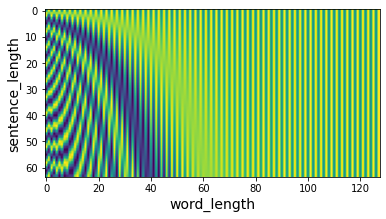

torch.Size([292, 64, 4])

In [19]:
# data (B,S,W)
# PE class instantiation (W,dropout,S)
# PE call function (S,W) = PE(pos,i), i in [0,1,2,...,d_model-1] = sin(pos/10000^(2*i/dmodel)) if i%2==0 else cos(pos/10000^(2*i/dmodel))
class PositionalEncoding(nn.Module): # e.g. S=64, W=d_model=4
    def __init__(self, d_model:int, dropout:float=0.1, max_len:int=5000): # (W,-,S)
        super().__init__() # must because self.register_buffer
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)   # [[0],[1],[2],...,[5000]]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # torch.arange(0,4,2)=[0,2]
        # div_term = e^([0,2]*(-log_e(10000))*1/d) = (e^(log_e(10000)))^([0,2]*(-1/dmodel)) = 1/10000^([0,2]/dmodel)
        pe = torch.zeros(max_len, 1, d_model)           # (S,1,W)
        pe[:, 0, 0::2] = torch.sin(position * div_term) # (position*div_term).shape=(5000,1,64)
        pe[:, 0, 1::2] = torch.cos(position * div_term) # pe.shape=(5000,1,64)
        self.register_buffer('pe', pe) # remain at cpu and non-trainable
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)] # x.size(0)=S
        return self.dropout(x)

PE = PositionalEncoding(128,0,64) # (W,-,S)
plt.imshow(PE.pe[:,0,:])
plt.ylabel("sentence_length", fontsize=14)
plt.xlabel("word_length", fontsize=14)
plt.show()

PositionalEncoding(4,0)( torch.Tensor(xVal) ).shape

In [11]:
# reference only
attn = torch.nn.MultiheadAttention(4,2) # (W,H)
x = torch.rand(64,16,4) # (S,B,W)
a, _ = attn(x,x,x)
a.shape

torch.Size([64, 16, 4])

In [12]:
# reference only
encoder_layer = nn.TransformerEncoderLayer(d_model=4, nhead=2)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(64,16,4) # (S,B,W)
out = transformer_encoder(src)
out.shape # (S,B,W)

torch.Size([64, 16, 4])

In [13]:
# reference only
decoder_layer = nn.TransformerDecoderLayer(d_model=4, nhead=2)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(64,16,4) # (S,B,W)
tgt = torch.rand(64,16,4)
out = transformer_decoder(tgt, memory)
out.shape

torch.Size([64, 16, 4])

In [14]:
# reference only
transformer_model = nn.Transformer(d_model=4, nhead=2, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=128)
src = torch.rand((64,16,4))
tgt = torch.rand((64,16,4))
out = transformer_model(src, tgt)
out.shape

torch.Size([64, 16, 4])

### Model

In [48]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.positionalEncoding = PositionalEncoding(d_model=4, dropout=0, max_len=64)
        self.transformer = nn.Transformer(d_model=4, nhead=2, num_encoder_layers=12, num_decoder_layers=6, dim_feedforward=2048)
        self.mask = torch.zeros(64,16,4).to('cuda') # S,B,W
        if True:
            self.mask = torch.Tensor([[-999]*4 for i in range(64)])
            self.mask = self.mask.triu(diagonal=1)
            self.mask = torch.stack([ self.mask for i in range(16) ])
            self.mask = self.mask.permute(1,0,2).to('cuda')
        self.dense = torch.nn.Linear(64*4,4)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        x = self.positionalEncoding(x)
        x = x.to('cuda')
        x = self.transformer(x, self.mask)
        x = x.permute(1,0,2)
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x
    
model = MyModel().to('cuda')

with torch.no_grad():
    pred = model( next(iter(trainDataLoader))[0].to('cuda') )
    print( pred.shape )

torch.Size([16, 4])


In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

epochs = 20
history = {"trainLossL":[], "valLossL":[]}
for ep in range(epochs):
    print(f"Epoch: {ep+1}/{epochs}")
    # train
    trainLoss= 0.
    for i,(X,y) in enumerate(trainDataLoader):
        X, y = X.to('cuda'), y.to('cuda')
        optimizer.zero_grad()    # zero the parameter gradients
        pred = model(X)          # f(x) and f'(x)
        loss = loss_func(y,pred)    # compute loss
        loss.backward()          # send loss to torch
        optimizer.step()         # update model parameters by torch loss 
        trainLoss += loss.item() / len(trainDataset)
        print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}", end="")
    history["trainLossL"].append(trainLoss)
    # validation
    valLoss = 0.
    for i,(X,y) in enumerate(valDataLoader):
        y = y.to('cuda')
        with torch.no_grad():
            X, y = X.to('cuda'), y.to('cuda')
            pred = model(X)
            loss = loss_func(pred,y)
            valLoss += loss.item() / len(valDataset)
            print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}", end="")
    history["valLossL"].append(valLoss)
    print()

Epoch: 1/20
batch=18/18, valLoss=0.0147033
Epoch: 2/20
batch=18/18, valLoss=0.0103721
Epoch: 3/20
batch=18/18, valLoss=0.0095798
Epoch: 4/20
batch=18/18, valLoss=0.0096120
Epoch: 5/20
batch=18/18, valLoss=0.0089653
Epoch: 6/20
batch=18/18, valLoss=0.0104366
Epoch: 7/20
batch=18/18, valLoss=0.0054293
Epoch: 8/20
batch=18/18, valLoss=0.0050622
Epoch: 9/20
batch=18/18, valLoss=0.0046186
Epoch: 10/20
batch=18/18, valLoss=0.0045995
Epoch: 11/20
batch=18/18, valLoss=0.0042741
Epoch: 12/20
batch=18/18, valLoss=0.0037921
Epoch: 13/20
batch=18/18, valLoss=0.0046914
Epoch: 14/20
batch=18/18, valLoss=0.0041532
Epoch: 15/20
batch=18/18, valLoss=0.0038008
Epoch: 16/20
batch=18/18, valLoss=0.0033585
Epoch: 17/20
batch=18/18, valLoss=0.0038918
Epoch: 18/20
batch=18/18, valLoss=0.0034782
Epoch: 19/20
batch=18/18, valLoss=0.0047589
Epoch: 20/20
batch=18/18, valLoss=0.0033021


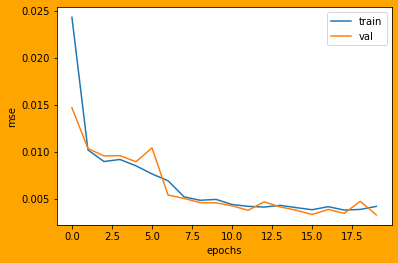

In [51]:
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['trainLossL'])
plt.plot(history['valLossL'])
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend(labels=['train','val'])
plt.show()

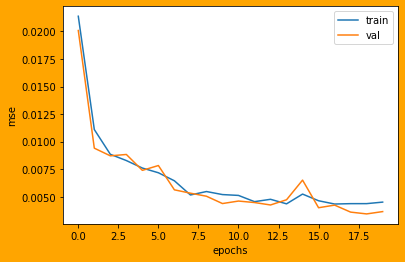

In [23]:
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['trainLossL'])
plt.plot(history['valLossL'])
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend(labels=['train','val'])
plt.show()

In [27]:
with torch.no_grad():
    realL, predL = np.array([[0,0,0,0]]), np.array([[0,0,0,0]])
    for X,y in valDataLoader:
        realL = np.concatenate([realL,y])
        pred = model(X.to('cuda')).cpu().numpy()
        predL = np.concatenate([predL,pred])
    realL, predL = realL[1:], predL[1:]
    
print(realL.shape, predL.shape)

(288, 4) (288, 4)


In [28]:
real = realL*np.array(stds)+np.array(means)
pred = predL*np.array(stds)+np.array(means)

D = { **{f"real_{i}":real[:,i] for i in range(4)}, **{f"pred_{i}":pred[:,i] for i in range(4)} }
df = pd.DataFrame( D )
df

,real_0,real_1,real_2,real_3,pred_0,pred_1,pred_2,pred_3
0,322.700004,74.416548,360.910017,66.694283,339.923036,74.865992,678.977925,55.078994
1,1614.370004,288.124722,3375.330058,344.709992,1722.594727,272.293046,5195.387579,315.694489
2,1990.000031,283.310367,6491.999900,369.950001,1782.507719,273.306720,5820.723313,311.826284
3,326.439993,63.157846,202.990074,50.712856,327.381039,75.989431,849.485400,45.746866
4,326.279984,70.907421,504.799938,64.504288,355.452630,80.598171,335.399271,47.825378
...,...,...,...,...,...,...,...,...
283,744.429989,140.970840,651.109897,85.990001,640.054268,131.498139,958.963541,108.198517
284,292.709980,67.875771,441.109905,45.791431,351.538017,78.904521,873.378906,44.424863
285,1159.790029,177.052568,16850.310356,185.199996,1071.792668,163.955425,10715.506249,216.613698
286,372.369984,74.810203,658.299953,64.785716,318.070791,73.739171,439.864266,45.107493


In [34]:
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense = torch.nn.Linear(64*4,4)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x
    
model = MyModel2()#.to('cuda')

with torch.no_grad():
    pred = model( next(iter(trainDataLoader))[0] )
    print( pred.shape )

torch.Size([16, 4])


In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

epochs = 20
history = {"trainLossL":[], "valLossL":[]}
for ep in range(epochs):
    print(f"Epoch: {ep+1}/{epochs}")
    # train
    trainLoss= 0.
    for i,(X,y) in enumerate(trainDataLoader):
        optimizer.zero_grad()    # zero the parameter gradients
        pred = model(X)          # f(x) and f'(x)
        loss = loss_func(y,pred)    # compute loss
        loss.backward()          # send loss to torch
        optimizer.step()         # update model parameters by torch loss 
        trainLoss += loss.item() / len(trainDataset)
    print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}", end="")
    history["trainLossL"].append(trainLoss)
    # validation
    valLoss = 0.
    for i,(X,y) in enumerate(valDataLoader):
        with torch.no_grad():
            pred = model(X)
            loss = loss_func(pred,y)
            valLoss += loss.item() / len(valDataset)
    print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}", end="")
    history["valLossL"].append(valLoss)
    print()
    #break

Epoch: 1/20
batch=18/18, valLoss=0.0329379
Epoch: 2/20
batch=18/18, valLoss=0.0140874
Epoch: 3/20
batch=18/18, valLoss=0.0106581
Epoch: 4/20
batch=18/18, valLoss=0.0082432
Epoch: 5/20
batch=18/18, valLoss=0.0064451
Epoch: 6/20
batch=18/18, valLoss=0.0051820
Epoch: 7/20
batch=18/18, valLoss=0.0043129
Epoch: 8/20
batch=18/18, valLoss=0.0037366
Epoch: 9/20
batch=18/18, valLoss=0.0033424
Epoch: 10/20
batch=18/18, valLoss=0.0030795
Epoch: 11/20
batch=18/18, valLoss=0.0028774
Epoch: 12/20
batch=18/18, valLoss=0.0027258
Epoch: 13/20
batch=18/18, valLoss=0.0026045
Epoch: 14/20
batch=18/18, valLoss=0.0025034
Epoch: 15/20
batch=18/18, valLoss=0.0024024
Epoch: 16/20
batch=18/18, valLoss=0.0023216
Epoch: 17/20
batch=18/18, valLoss=0.0022408
Epoch: 18/20
batch=18/18, valLoss=0.0021700
Epoch: 19/20
batch=18/18, valLoss=0.0021193
Epoch: 20/20
batch=18/18, valLoss=0.0020487


In [36]:
with torch.no_grad():
    realL, predL = np.array([[0,0,0,0]]), np.array([[0,0,0,0]])
    for X,y in valDataLoader:
        realL = np.concatenate([realL,y])
        pred = model(X).numpy()
        predL = np.concatenate([predL,pred])
    realL, predL = realL[1:], predL[1:]
    
print(realL.shape, predL.shape)

(288, 4) (288, 4)


In [37]:
real = realL*np.array(stds)+np.array(means)
pred = predL*np.array(stds)+np.array(means)

D = { **{f"real_{i}":real[:,i] for i in range(4)}, **{f"pred_{i}":pred[:,i] for i in range(4)} }
df = pd.DataFrame( D )
df

,real_0,real_1,real_2,real_3,pred_0,pred_1,pred_2,pred_3
0,322.700004,74.416548,360.910017,66.694283,329.089093,75.882828,477.925146,62.985200
1,1614.370004,288.124722,3375.330058,344.709992,1755.219823,260.774598,4240.529065,315.965511
2,1990.000031,283.310367,6491.999900,369.950001,1904.397929,283.755417,6250.277542,373.089856
3,326.439993,63.157846,202.990074,50.712856,267.649656,65.161037,259.202125,42.309344
4,326.279984,70.907421,504.799938,64.504288,323.806312,72.943598,688.020653,57.739553
...,...,...,...,...,...,...,...,...
283,744.429989,140.970840,651.109897,85.990001,629.138729,128.412123,683.706895,101.561739
284,292.709980,67.875771,441.109905,45.791431,306.774592,70.960038,520.780910,54.578615
285,1159.790029,177.052568,16850.310356,185.199996,1197.940669,189.841660,8789.052815,198.177198
286,372.369984,74.810203,658.299953,64.785716,337.260370,69.552210,564.609188,61.656409


In [31]:
lstm = nn.LSTM(input_size=4, hidden_size=128, num_layers=3)
x = torch.randn(64,16,4) # (S,B,W)
output, _ = lstm(x)
output.shape

torch.Size([64, 16, 128])

In [42]:
class MyModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=4, num_layers=3)
        self.dense = torch.nn.Linear(64*4,4)
        
    def forward(self, x):
        x, (_, _) = self.lstm(x)
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x
    
model = MyModel3()#.to('cuda')

with torch.no_grad():
    pred = model( next(iter(trainDataLoader))[0] )
    print( pred.shape )

torch.Size([16, 4])


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

epochs = 100
history = {"trainLossL":[], "valLossL":[]}
for ep in range(epochs):
    print(f"Epoch: {ep+1}/{epochs}")
    # train
    trainLoss= 0.
    for i,(X,y) in enumerate(trainDataLoader):
        optimizer.zero_grad()    # zero the parameter gradients
        pred = model(X)          # f(x) and f'(x)
        loss = loss_func(y,pred)    # compute loss
        loss.backward()          # send loss to torch
        optimizer.step()         # update model parameters by torch loss 
        trainLoss += loss.item() / len(trainDataset)
        print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}", end="")
    history["trainLossL"].append(trainLoss)
    # validation
    valLoss = 0.
    for i,(X,y) in enumerate(valDataLoader):
        with torch.no_grad():
            pred = model(X)
            loss = loss_func(pred,y)
            valLoss += loss.item() / len(valDataset)
            print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}", end="")
    history["valLossL"].append(valLoss)
    print()

Epoch: 1/100
batch=18/18, valLoss=0.0613783
Epoch: 2/100
batch=18/18, valLoss=0.0613138
Epoch: 3/100
batch=18/18, valLoss=0.0612122
Epoch: 4/100
batch=18/18, valLoss=0.0609699
Epoch: 5/100
batch=18/18, valLoss=0.0605257
Epoch: 6/100
batch=18/18, valLoss=0.0598290
Epoch: 7/100
batch=18/18, valLoss=0.0588089
Epoch: 8/100
batch=18/18, valLoss=0.0574351
Epoch: 9/100
batch=18/18, valLoss=0.0557073
Epoch: 10/100
batch=18/18, valLoss=0.0536358
Epoch: 11/100
batch=18/18, valLoss=0.0512713
Epoch: 12/100
batch=18/18, valLoss=0.0487045
Epoch: 13/100
batch=18/18, valLoss=0.0459962
Epoch: 14/100
batch=18/18, valLoss=0.0432073
Epoch: 15/100
batch=18/18, valLoss=0.0403982
Epoch: 16/100
batch=18/18, valLoss=0.0376095
Epoch: 17/100
batch=18/18, valLoss=0.0348914
Epoch: 18/100
batch=18/18, valLoss=0.0323044
Epoch: 19/100
batch=18/18, valLoss=0.0298489
Epoch: 20/100
batch=18/18, valLoss=0.0275750
Epoch: 21/100
batch=18/18, valLoss=0.0254830
Epoch: 22/100
batch=18/18, valLoss=0.0235830
Epoch: 23/100
batch